In [1]:
# import necessary modules
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from evaluation import test
from utils import load_data, predict_image

from sklearn import datasets
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import linear_model

from lr import LogisticRegression

Examples

https://github.com/beckernick/logistic_regression_from_scratch

https://github.com/martinpella/logistic-reg/blob/master/logistic_reg.ipynb    

What can you do after implementing logistic regression?

We can do binary classification.

In [ ]:
iris = datasets.load_iris()
iris.data.shape

In [ ]:
X = iris.data[:, :2]
y = (iris.target != 0) * 1
# combine label 1, 2 into 1
pd.DataFrame(X).describe()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
plt.legend();

In [ ]:
model = LogisticRegression(num_iterations=300000, learning_rate=0.1, fit_intercept=True)

In [ ]:
%time model.fit(X, y)

In [ ]:
model.weights
preds = model.predict(X)
print('Confusion Matrix: \n', confusion_matrix(y,preds))    
print('Accuracy: ', accuracy_score(y, preds))

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='b', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='r', label='1')
plt.legend()
x1_min, x1_max = X[:,0].min(), X[:,0].max(),
x2_min, x2_max = X[:,1].min(), X[:,1].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
grid = np.c_[xx1.ravel(), xx2.ravel()]
probs = model.predict_prob(grid).reshape(xx1.shape)
plt.contour(xx1, xx2, probs, [0.5], linewidths=1, colors='black');

In [ ]:
np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))
pd.DataFrame(simulated_separableish_features).describe()
model = LogisticRegression(num_iterations=300000, learning_rate =.1, fit_intercept=True,
                            print_cost=True)
model.fit(simulated_separableish_features, simulated_labels)
print(model.weights)
skclf = linear_model.LogisticRegression(penalty='none', fit_intercept=True, solver='lbfgs')
skclf.fit(simulated_separableish_features, simulated_labels)
print(skclf.intercept_, skclf.coef_)

Another alternative Logistic regression is update weights using SGD

Image classification using logistic regression

In [2]:
from utils import load_cat_dataset
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_cat_dataset()
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.
X_train = train_set_x.T
X_test = test_set_x.T
y_train = train_set_y.flatten()
y_test = test_set_y.flatten()

In [3]:
skclf = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)

In [4]:
skclf = test(skclf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00        72

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209

Confusion Matrix: 
 [[137   0]
 [  0  72]]

Accuracy:  1.0
              precision    recall  f1-score   support

           0       0.57      0.76      0.65        17
           1       0.85      0.70      0.77        33

    accuracy                           0.72        50
   macro avg       0.71      0.73      0.71        50
weighted avg       0.75      0.72      0.73        50

Confusion Matrix: 
 [[13  4]
 [10 23]]

Accuracy:  0.72


y = 1, your algorithm predicts a "cat" picture.


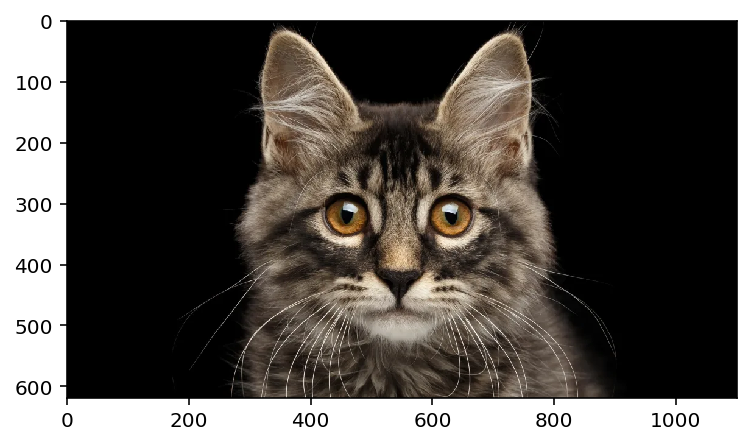

In [5]:
num_px = train_set_x_orig.shape[1]
cat_image = "my_image3.jpg"   # change this to the name of your image file 
predict_image(clf= skclf, fname=cat_image, num_px=num_px, classes=classes)

y = 0, your algorithm predicts a "non-cat" picture.


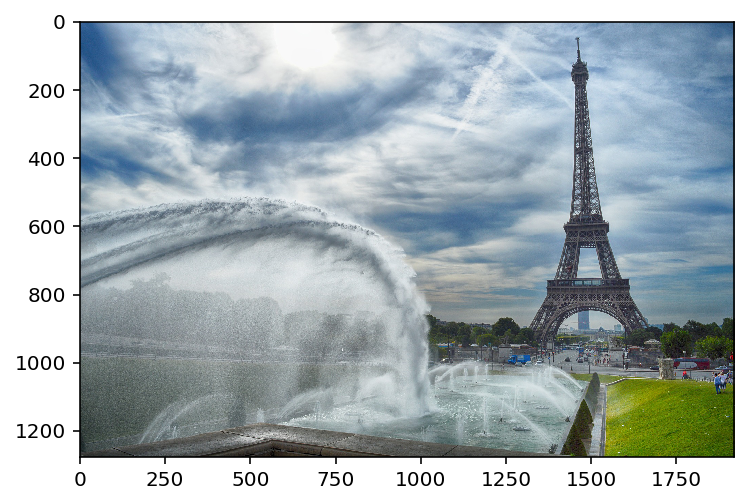

In [6]:
not_cat_image = "my_image.jpg"
predict_image(clf= skclf, fname=not_cat_image, num_px=num_px, classes=classes)

Can our own implementation of Logistic Regression perform the same task?
Let's check

In [7]:
clf = LogisticRegression(num_iterations=3000, learning_rate=0.1, fit_intercept=True, print_cost=False)

In [8]:
test(clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00        72

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209

Confusion Matrix: 
 [[137   0]
 [  0  72]]

Accuracy:  1.0
              precision    recall  f1-score   support

           0       0.50      0.65      0.56        17
           1       0.79      0.67      0.72        33

    accuracy                           0.66        50
   macro avg       0.64      0.66      0.64        50
weighted avg       0.69      0.66      0.67        50

Confusion Matrix: 
 [[11  6]
 [11 22]]

Accuracy:  0.66


y = 1.0, your algorithm predicts a "cat" picture.


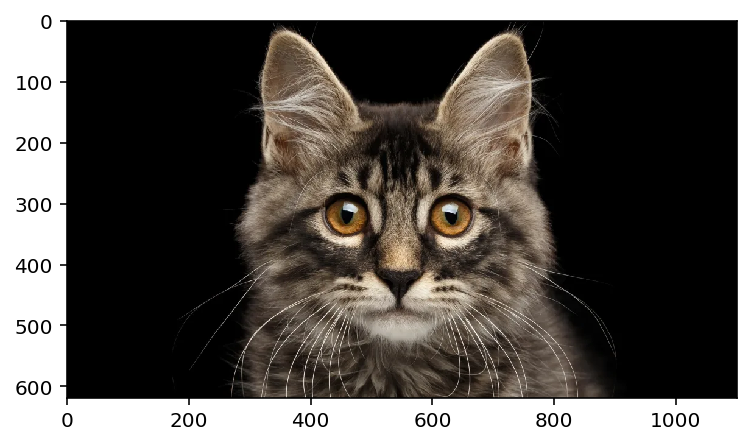

In [10]:
predict_image(clf= clf, fname=cat_image, num_px=num_px, classes=classes)

y = 0.0, your algorithm predicts a "non-cat" picture.


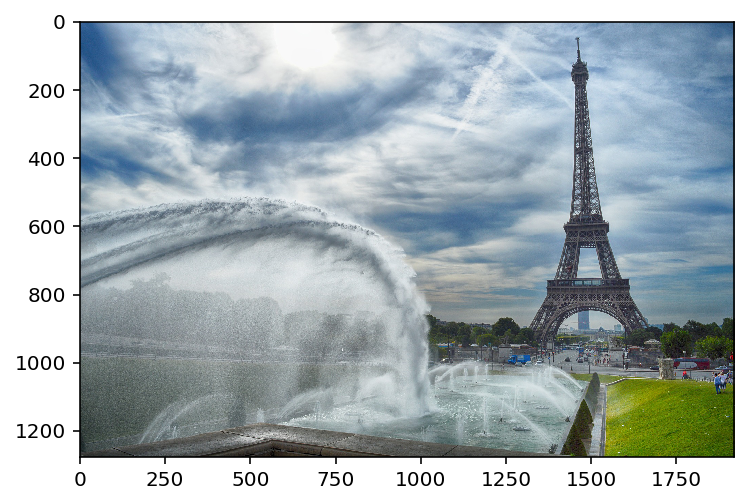

In [11]:
predict_image(clf= clf, fname=not_cat_image, num_px=num_px, classes=classes)